### **SIV Project**
---
Project by Christian Dal Farra and Marco Panciera,

this project implement the article [DETECTING POTHOLES USING SIMPLE IMAGE PROCESSING TECHNIQUES AND REAL-WORLD FOOTAGE](https://www.researchgate.net/publication/279538022_Detecting_Potholes_Using_Simple_Image_Processing_Techniques_and_Real-World_Footage)

Prima di sta roba metti la versione di python e ambiente virtuale(probabile 3.10 per far andare DeepLabV3 che è preallenato per la segmentazione se vogliamo metterlo se no amen) per l'ambiente virtuale e il codice per installare tutte le librerie che servono (pip install -r "requirements.txt")

Start importing some libraries that we need

In [1]:
#pip install -r "requirements.txt"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Import the image

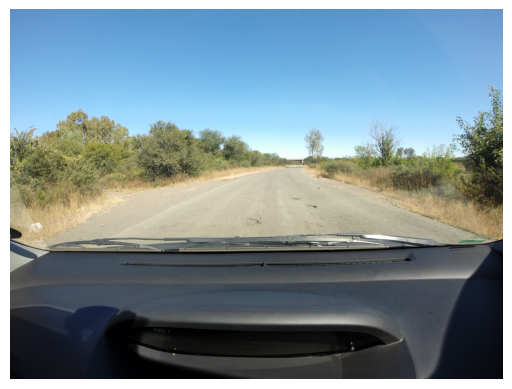

In [3]:
image_path = 'test_images/test1.jpg'
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Immagine non trovata o percorso errato!")

image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.axis('off')
plt.imshow(image_rgb)

Here there is an image that shows the pipeline, the **image are taken by a camera mounted inside the vehicle**  on the front windscreen, for more accurately develop a device that can be fitted to a vehicle for commercial use, we found the dataset used for some practical testing at that link [NinjaDataset](https://datasetninja.com/road-pothole-images)

![Alt text](presentation_images/algortihm_block_diagram.png "Algortihm block scheme")

In [4]:
#Extract Road Area
#Color Model
def identify_road_color(image, roi_coords):
    """Identifica il colore medio della strada basandosi su una regione di interesse (ROI)."""
    roi = image[roi_coords[1]:roi_coords[3], roi_coords[0]:roi_coords[2]]
    mean_color = np.mean(roi, axis=(0, 1))
    std_color = np.std(roi, axis=(0, 1))
    lower_bound = np.clip(mean_color - 3 * std_color, 0, 255)
    upper_bound = np.clip(mean_color + 3 * std_color, 0, 255)
    return lower_bound.astype(np.uint8), upper_bound.astype(np.uint8)

#Contour definition
def extract_road_contours(image, lower_bound, upper_bound):
    """Estrae i contorni della strada basandosi sul modello di colore."""
    mask = cv2.inRange(image, lower_bound, upper_bound)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours, mask

In [5]:
#Improve road Segmentation
def convex_hull_contours(contours):
    """Applica il convex hull per raffinare i contorni."""
    return [cv2.convexHull(cnt) for cnt in contours]

def process_image(image):
    """Elabora l'immagine per evidenziare i bordi della strada."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # L'immagine è già in scala di grigi
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

def refine_edges(edges):
    """Raffina i bordi applicando operazioni morfologiche."""
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    return dilated

def detect_potholes(edges, min_size=50):
    """Identifica le buche basandosi sui contorni scuri all'interno della strada."""
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    potholes = [cnt for cnt in contours if cv2.contourArea(cnt) > min_size]
    return potholes

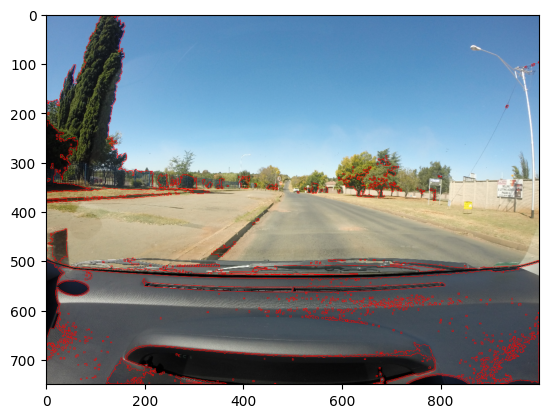

In [6]:
def main(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (1000, 750))
    roi_coords = (200, 200, 800, 500)  # Esempio di ROI sopra il cofano (x_min,y_min,x_max,y_max)
    lower_bound, upper_bound = identify_road_color(image_resized, roi_coords)
    _, mask = extract_road_contours(image, lower_bound, upper_bound)
    refined_edges = refine_edges(process_image(mask))
    potholes = detect_potholes(refined_edges)
    
    output = image.copy()
    cv2.drawContours(output, potholes, -1, (0, 0, 255), 2)
    output_resized = cv2.resize(output, (1000, 750))  # Ridimensiona l'output
    rgb = cv2.cvtColor(output_resized, cv2.COLOR_RGB2BGR)
    plt.imshow(rgb)


if __name__ == "__main__":
    main("test_images/test2.jpg")